# Inference in Pyro

In [1]:
import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as pdist

Assume we have the following model of noisy measurement of some weight:
$$
\text{weight }|\text{ guess} \sim \mathcal{N}(\text{guess},1) \\
\text{measurement }|\text{ guess, weight} \sim \mathcal{N}(\text{weight}, 0.75)
$$
The first distribution encodes our prior over the weight of the object given some initial guess of its weight, and the second distribution models the noise in the system.

In [2]:
def scale(guess):
    weight = pyro.sample("weight", pdist.Normal(guess, 1))
    return pyro.sample("measurement", pdist.Normal(weight, 0.75))

If we want to find the weight of the object, we need to condition our model on some observed data and infer the latent factors (in this case the weight) that might have produced the data. For example, say we make an initial guess that something weighs 8.5, but our measurement returns 9.5; what's the posterior distribution of weights
$$
\left(\text{weight }|\text{ guess, measurement}\right) \sim ?
$$
Pyro allows us to condition on certain variables using `pyro.condition`:

In [3]:
def deferred_conditioned_scale(measurement, guess):
    return pyro.condition(scale, data={"measurement": measurement})(guess)

deferred_conditioned_scale(9.5, 8.5)

9.5

In [4]:
def scale_obs(guess):
    weight = pyro.sample("weight", pdist.Normal(guess, 1.))
    return pyro.sample("measurement", pdist.Normal(weight, 0.75), obs=9.5)

scale_obs(8.5)

/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:86: RuntimeWarning: trying to observe a value outside of inference at measurement
  RuntimeWarning)


9.5

It doesn't seem to do anything (just returns the observed value), but we can now use it to do inference with some of Pyro's built-in algorithms. The posterior of the above model isn't actually that interesting because it can be calculated analytically as $\text{weight} \sim \mathcal{N}(9.14, 0.6)$. But we will continue onwards and try and see if we can recover these parameters.

We can use `pyro.param` to create a model for the posterior by specifying a "guide function" for variational inference that has the flexibility to approximately model the posterior using specified parameters:

In [25]:
from torch.distributions import constraints

def model():
    guess = torch.tensor(8.5)
    weight = pyro.sample("weight", pdist.Normal(guess, 1))
    return pyro.sample("measurement", pdist.Normal(weight, 0.75))

def guide():
    a = pyro.param("a", torch.tensor(8.5))
    b = pyro.param("b", torch.tensor(1.), constraint=constraints.positive)
    return pyro.sample("weight", pdist.Normal(a, b))

Then we can run the SVI (Stochastic Variational Inference) algorithm to optimize our guide posterior so that it matches the actual posterior as closely as possible. The loss function that we will be maximizing is ELBO (Evidence Lower BOund); it is not exactly the same thing as maximizing the likelihood, but the ELBO is a lower bound (hence the name) for the likelihood so that maximizing it tends to maximize the likelihood as well. The derivation is simple and follows easily from Jensen's inequality.

In [ ]:
pyro.clear_param_store()
svi = pyro.infer.SVI(
    model=pyro.condition(model, data={"measurement": 9.5}),
    guide=guide,
    optim=pyro.optim.Adam({"lr": 5e-4}),
    loss=pyro.infer.Trace_ELBO(),
)

losses, a, b = [], [], []
num_steps = 10000
for t in tqdm.notebook.tqdm(range(num_steps)):
    losses.append(svi.step())
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

a =  9.131595611572266
b =  0.6017813086509705


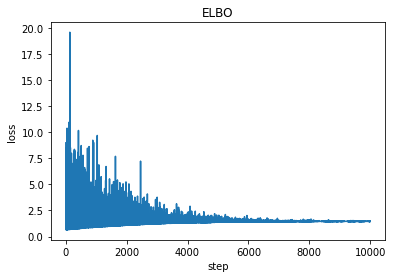

In [23]:
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
print("a = ", pyro.param("a").item())
print("b = ", pyro.param("b").item())

We can see that the parameters $a$ and $b$ eventually converge to the expected answers that we got from the analytic derivation:

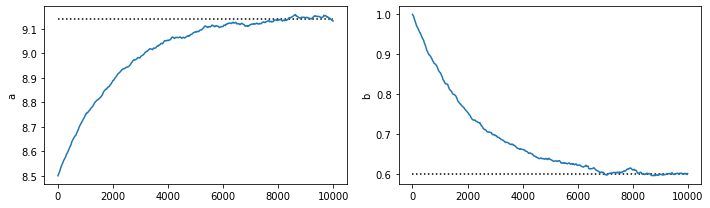

In [24]:
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.plot([0,num_steps],[9.14,9.14], 'k:')
plt.plot(a)
plt.ylabel('a')

plt.subplot(1,2,2)
plt.ylabel('b')
plt.plot([0,num_steps],[0.6,0.6], 'k:')
plt.plot(b)
plt.tight_layout()